In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from Plot_tools import *

from skimage.measure import label
import time
import multiprocessing as mp

# define a grid to interpolation profiles to

zhgts = 250. + 250.*np.arange(60)

_nthreads = 2
percent = (75,90,95)


#---------------------------------------------------------------------------------------------

class TimerError(Exception):
    """A custom exception used to report errors in use of Timer class"""

class Timer:
    def __init__(self):
        self._start_time = None

    def start(self):
        """Start a new timer"""
        if self._start_time is not None:
            raise TimerError(f"Timer is running. Use .stop() to stop it")

        self._start_time = time.perf_counter()

    def stop(self):
        """Stop the timer, and report the elapsed time"""
        if self._start_time is None:
            raise TimerError(f"Timer is not running. Use .start() to start it")

        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")

#---------------------------------------------------------------------
def interp3dz_np(data, z3d, z1d, nthreads = 10):
    
    if data.ndim == 2:
    
        dinterp = np.zeros((len(z1d),data.shape[1]),dtype=np.float32)

        if nthreads < 0:  # turning this off for now.
            def worker(j):
                print("running %d %s" % (i, data.shape))
                dinterp[:,j] = np.interp(z1d, z3d[:,j], data[:,j])

            pool = mp.Pool(nthreads)
            for i in np.arange(data.shape[2]):
                pool.apply_async(worker, args = (i, ))
            pool.close()
            pool.join()

            return dinterp

        else:        
            for j in np.arange(data.shape[1]):
                dinterp[:,j] = np.interp(z1d, z3d[:,j], data[:,j])
    
        return dinterp

#---------------------------------------------------------------------
def interp4Dz_np(data, z3d, z1d, nthreads = 10):
    
    dinterp = np.zeros((data.shape[0],len(z1d),data.shape[2],data.shape[3]),dtype=np.float32)

    if nthreads > 0:  # turning this off for now.
        def worker(t,j,i):
            print("running %d %s" % (t, data.shape))
            dinterp[t,:,j,i] = np.interp(z1d, z3d[t,:,j,i], data[t,:,j,i])

        pool = mp.Pool(nthreads)
        for t in np.arange(data.shape[0]):
            for j in np.arange(data.shape[2]):
                for i in np.arange(data.shape[3]):
                    pool.apply_async(worker, args = (t, j, i, ))
        pool.close()
        pool.join()

        return dinterp

    else:       
        
        for t in np.arange(data.shape[0]):
            for j in np.arange(data.shape[2]):
                for i in np.arange(data.shape[3]):
                    dinterp[t,:,j,i] = np.interp(z1d, z3d[t,:,j,i], data[t,:,j,i])

        return dinterp
#---------------------------------------------------------------------
def write_Z_profile(data, model='WRF', tindex=0, iloc=0, jloc=0,  data_keys = ['z3d', 'pres', 'theta', 'den', 'ppres']):
    
    from columnar import columnar
    
    print('#-----------------------------#')
    print('          %s                  ' % model)
    print('#-----------------------------#')
    
    newlist = []
    newlist.append(np.arange(data['z3d'].shape[1]).tolist())
    
    headers = ['level']
    
    for key in data_keys:
        
        newlist.append(data[key][tindex,:,iloc,jloc].tolist())
        headers.append(key)

    # need to rearange all the data into row like an excel spreadsheet
    
    row_data = [list(x) for x in zip(*newlist)]
        
    table = columnar(row_data, headers, no_borders=True)
    print(table)


In [26]:
def read_model_fields(run_dir, model_type='wrf', printout=False, filename=None):
    
    if model_type == 'fv3_raw':
        
        if filename != None:
            print("Reading:  %s " % os.path.join(run_dir,filename))
            ds = xr.open_dataset(os.path.join(run_dir,filename))
        else:
            ds = xr.open_dataset(os.path.join(run_dir, "fv3_history*.nc"))
        
        z3d    = ds.delz.values[:,::-1,:,:]
        z3d    = - np.cumsum(z3d,axis=1)

        w      = ds.dzdt.values[:,::-1,:,:]

        pres   = ds.pres.values[:,::-1,:,:]
        pfull  = ds.pfull.values * 100.
        pbase  = np.broadcast_to(pfull[np.newaxis, :, np.newaxis, np.newaxis], pres.shape)[:,::-1,:,:]
        ppres  = pres - pbase
        pii    = (pres/100000.)**0.286

        tbase  = ds.tmp.values[0,::-1,-1,-1]
        tbase  = np.broadcast_to(tbase[np.newaxis, :, np.newaxis, np.newaxis], pii.shape) / pii
        theta  = ds.tmp.values[:,::-1,:,:] / pii
        thetap = theta - tbase
        
        den    =  pres / (287.04*(theta)*pii)
        
        ds.close()

        out = {'w': w, 'pbase': pbase, 'tbase': tbase, 'den': den, 'pii': pii, 'z3d': z3d, 'pres': pres, 'theta': theta, 'thetap':thetap, 'ppres': ppres}
        
        if printout:
            write_Z_profile(out, model=model_type.upper())
            
        return out

##################################

    if model_type == 'wrf':
        
        def open_mfdataset_list(data_dir, pattern, skip=0):
            """
            Use xarray.open_mfdataset to read multiple netcdf files from a list.
            """
            filelist = os.path.join(data_dir,pattern)
            
            if skip > 0:
                filelist = filelist[0:-1:skip]
                
            return xr.open_mfdataset(filelist, combine='nested', concat_dim=['Time'], parallel=True)
    
        ds   = open_mfdataset_list(run_dir,  "wrfout*")

        w      = ds.W.values
        w      = 0.5*(w[:,1:,:,:] + w[:,:-1,:,:])
        ppres  = ds.P.values
        pbase  = ds.PB.values
        pres   = ppres + ds.PB.values
        tbase  = ds.T_BASE.values + 300.
        tbase  = np.broadcast_to(tbase[:, :, np.newaxis, np.newaxis], w.shape)
        theta  = ds.T.values + 300.
        thetap = theta - tbase
        z      = ds.PHB.values/9.806
        pii    = (pres/100000.)**0.286
        den    =  pres / (287.04*(theta)*pii)
        z3d    = ds.PHB.values/9.806
        z3d    = 0.5*(z[:,1:,:,:] + z[:,:-1,:,:])
        
        ds.close()

        out = {'w': w, 'pbase': pbase, 'tbase': tbase, 'den': den, 'pii': pii, 'z3d': z3d, 'pres': pres, 'theta': theta, 'thetap':thetap, 'ppres': ppres}        
        
        if printout:
            write_Z_profile(out, model=model_type.upper())
            
        return out
    
    if model_type == 'fv3':
        
        def open_mfdataset_list(data_dir, pattern):
            """
            Use xarray.open_mfdataset to read multiple netcdf files from a list.
            """
            filelist = os.path.join(data_dir,pattern)
            return xr.open_mfdataset(filelist, combine='nested', concat_dim=['time'], parallel=True)
    
        ds   = open_mfdataset_list(run_dir,   "*.nc")

        w      = ds.W.values
        tbase  = ds.T.values[0,:,-1,-1] + 300.
        tbase  = np.broadcast_to(tbase[np.newaxis, :, np.newaxis, np.newaxis], w.shape)
        theta  = ds.T.values + 300.
        thetap = theta - tbase
        ppres  = ds.P.values
        pbase  = ds.PB.values
        pres   = ppres + pbase
        z3d    = ds.PHB.values/9.806
        pii    = (pres/100000.)**0.286
        den    =  pres / (287.04*(theta)*pii)
        
        ds.close()

        out = {'w': w, 'pbase': pbase, 'tbase': tbase, 'den': den, 'pii': pii, 'z3d': z3d, 'pres': pres, 'theta': theta, 'thetap':thetap, 'ppres': ppres}
        
        if printout:
            write_Z_profile(out, model=model_type.upper())
            
        return out

    if model_type == 'cm1':
        
        def open_mfdataset_list(data_dir, pattern):
            """
            Use xarray.open_mfdataset to read multiple netcdf files from a list.
            """
            filelist = os.path.join(data_dir,pattern)
            return xr.open_mfdataset(filelist, parallel=True)
    
        ds = open_mfdataset_list(run_dir,  "cm1out_0000*.nc")

        w      = ds.winterp.values
        tbase  = ds.th0.values
        thetap = ds.thpert.values
        theta  = thetap + tbase
        pres   = ds.prs.values
        ppres  = ds.prspert.values
        pbase  = ds.prs0.values
        pii    = (pres/100000.)**0.286
        den    = pres / (287.04*(thetap+tbase)*pii)
        z      = ds.zh.values * 1000. # heights are in km
        z3d    = np.broadcast_to(z[np.newaxis, :, np.newaxis, np.newaxis], w.shape)
        
        out = {'w': w, 'pbase': pbase, 'tbase': tbase, 'den': den, 'pii': pii, 'z3d': z3d, 'pres': pres, 'theta': theta, 'thetap':thetap, 'ppres': ppres}
        
        if printout:
            write_Z_profile(out, model=model_type.upper())
            
        return out
    

In [18]:
def generate_ideal_profiles(fields, w_thresh = 5.0, cref_thresh = 45., min_pix=1, percentiles=None):
        
    w      = fields['w']
    thetap = fields['thetap']
    ppres  = fields['ppres']
    den    = fields['den']
    z3d    = fields['z3d']
    
    profiles = compute_profiles(w, thetap, ppres, den, z3d, w_thresh = w_thresh, cref_thresh = cref_thresh, min_pix=min_pix, percentiles=percentiles)
    
    return profiles

#-------------------------------------------------------------------------------
def compute_profiles(W, T, P, D, Z, w_thresh = 5.0, cref_thresh = 45., min_pix=5, percentiles=None):
        
    wlist   = [] 
    plist   = []
    tlist   = []
    dlist   = []
    
    jloc  = [126,129]
    iloc  = [126,129]
    
    for n in np.arange(W.shape[0]): # loop over number of time steps.            
        
        # check to see if there are objects
        
        wraw    = W[n,:,jloc[0]:jloc[1],iloc[0]:iloc[1]]              # get w_raw profiles
        praw    = P[n,:,jloc[0]:jloc[1],iloc[0]:iloc[1]]              # get p_raw profiles
        zraw    = Z[n,:,jloc[0]:jloc[1],iloc[0]:iloc[1]]              # get z_raw profiles
        traw    = T[n,:,jloc[0]:jloc[1],iloc[0]:iloc[1]]              # get t_raw profiles
        draw    = D[n,:,jloc[0]:jloc[1],iloc[0]:iloc[1]]              # get den_raw profiles
        
        if(wraw.ndim > 2):
            wraw = np.reshape(wraw, (wraw.shape[0],wraw.shape[1]*wraw.shape[2]))      
            zraw = np.reshape(zraw, (zraw.shape[0],zraw.shape[1]*zraw.shape[2]))
            praw = np.reshape(praw, (praw.shape[0],praw.shape[1]*praw.shape[2]))
            traw = np.reshape(traw, (traw.shape[0],traw.shape[1]*traw.shape[2]))
            draw = np.reshape(draw, (draw.shape[0],draw.shape[1]*draw.shape[2]))

        wprofile = interp3dz_np(wraw, zraw, zhgts, nthreads = _nthreads)
        pprofile = interp3dz_np(praw, zraw, zhgts, nthreads = _nthreads)
        tprofile = interp3dz_np(traw, zraw, zhgts, nthreads = _nthreads)
        dprofile = interp3dz_np(draw, zraw, zhgts, nthreads = _nthreads)

        wlist.append([wprofile.mean(axis=1)],)
        plist.append([pprofile.mean(axis=1)],)
        tlist.append([tprofile.mean(axis=1)],)
        dlist.append([dprofile.mean(axis=1)],)
                            
    if( len(wlist) < 1 ):
        
        print("\n ---> Compute_Profiles found no objects...returning zeros ...\n")
        return [np.zeros((zhgts.shape[0],1)), np.zeros((zhgts.shape[0],1)), np.zeros((zhgts.shape[0],1))]
    
    else:
        
        wprofiles = np.squeeze(np.asarray(wlist), axis=1).transpose()
        pprofiles = np.squeeze(np.asarray(plist), axis=1).transpose()
        tprofiles = np.squeeze(np.asarray(tlist), axis=1).transpose()
        dprofiles = np.squeeze(np.asarray(dlist), axis=1).transpose()

        return {'w': wprofiles, 'p': pprofiles, 't': tprofiles, 'd':dprofiles}

In [12]:
# plot some time series...

# WRF baselines

in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = './'

wrf_fields = read_model_fields(str(os.path.join(in_dir, "WRF_bubble_5K_10s")), model_type='wrf', printout=False)
wrf_profiles = generate_ideal_profiles(wrf_fields, w_thresh = 5.0, cref_thresh = 45., min_pix=1, percentiles=None)


In [13]:
# FV3 control

in_dir  = "/scratch/larissa.reames/ideal_updrafts"
out_dir = './'

fv3_fields = read_model_fields(str(os.path.join(in_dir, "FV3_bubble_5K_10s")), model_type='fv3', printout=False)
fv3_profiles = generate_ideal_profiles(fv3_fields, w_thresh = 5.0, cref_thresh = 45., min_pix=1, percentiles=None)


In [ ]:
print(fv3_fields)

In [32]:
# CM1

input_dir  = '/work/wicker/cm1r20.3/run_dry'
output_dir = './'

cm1_fields  = read_model_fields(str(os.path.join(input_dir, "bble_5K")), model_type='cm1', printout=False)
cm1_profiles = generate_ideal_profiles(cm1_fields, w_thresh = 5.0, cref_thresh = 45., min_pix=1, percentiles=None)


In [27]:
# FV3 test run

in_dir  = "/scratch/larissa.reames/ideal_updrafts/FV3_bubble_newinit"
out_dir = './'

fv3_test = read_model_fields(in_dir, filename = "fv3_history.nc", model_type='fv3_raw', printout=False)
fv3_test_profiles = generate_ideal_profiles(fv3_test, w_thresh = 5.0, cref_thresh = 45., min_pix=1, percentiles=None)


Reading:  /scratch/larissa.reames/ideal_updrafts/FV3_bubble_newinit/fv3_history.nc 


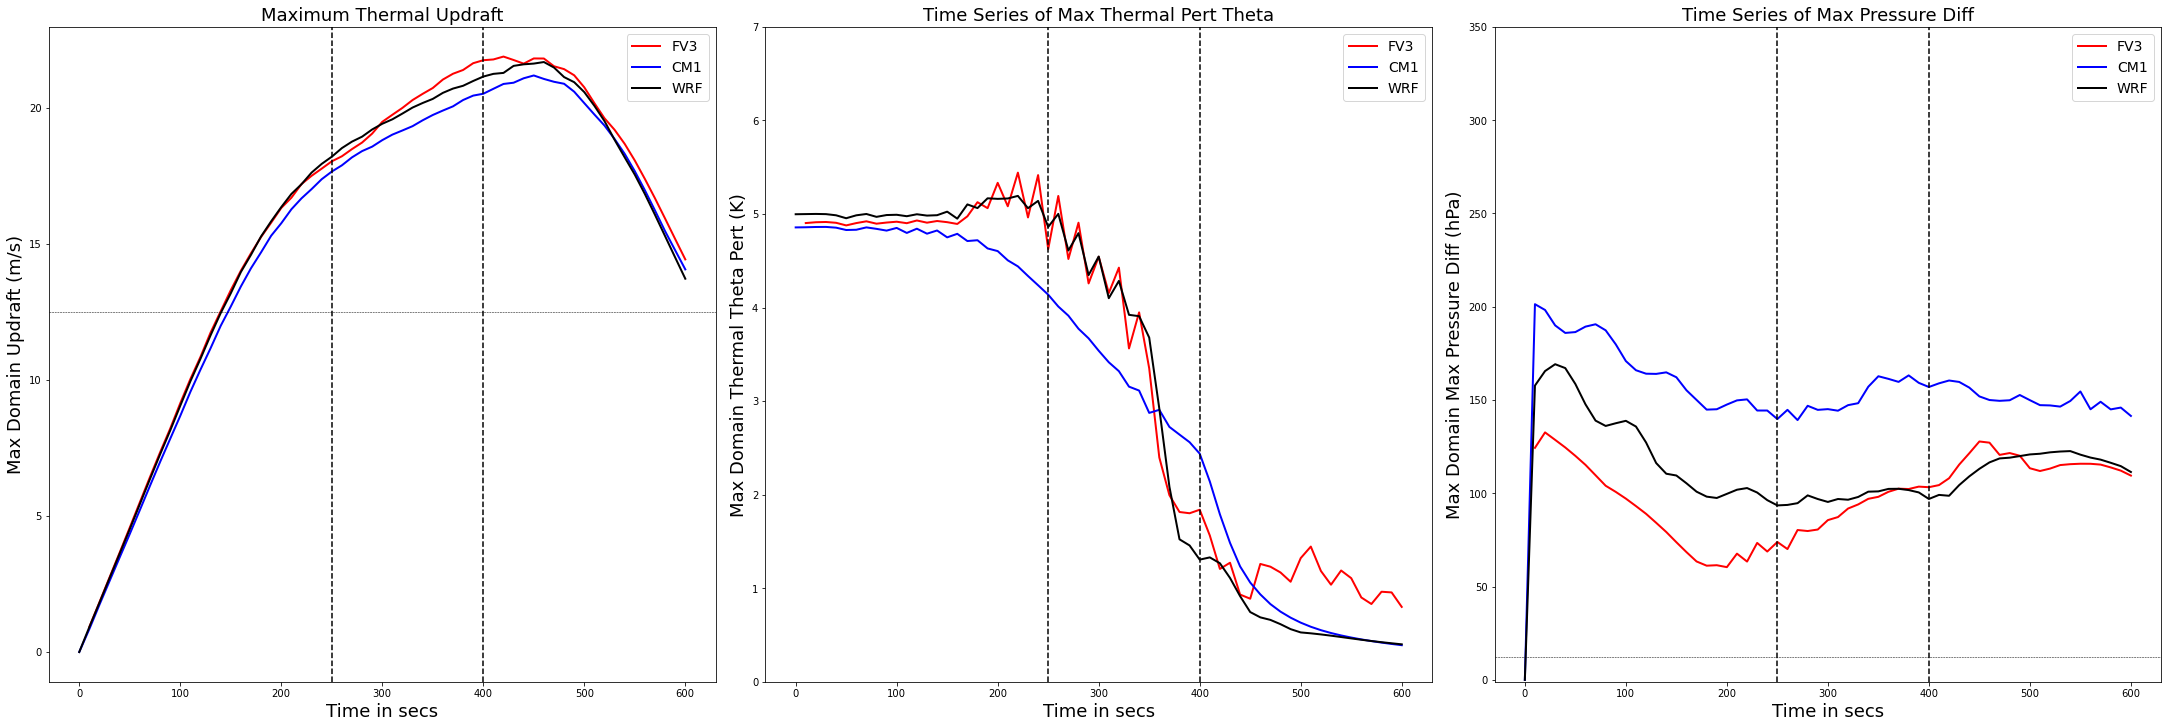

In [39]:
fig, axes = plt.subplots(1,3, constrained_layout=True,figsize=(30,10))

ax = axes[0]
ax.plot(10+np.arange(60)*10, fv3_test['w'].max(axis=(1,2,3)), color='r', linewidth=2.0, label='FV3')
ax.plot(np.arange(61)*10, cm1_fields['w'].max(axis=(1,2,3)), color='b', linewidth=2.0, label='CM1')
ax.plot(np.arange(61)*10, wrf_fields['w'].max(axis=(1,2,3)), color='k', linewidth=2.0, label='WRF')
ax.set_title("Maximum Thermal Updraft", fontsize=18)
ax.set_ylabel("Max Domain Updraft (m/s)", fontsize=18)
ax.set_xlabel("Time in secs", fontsize=18)
ax.axhline(y=12.5, color='k', linestyle='--',linewidth=0.5)
ax.axvline(x=250, color='k', linestyle='--')
ax.axvline(x=400, color='k', linestyle='--')
ax.legend(fontsize=14)

ax = axes[1]

ax.plot(10+np.arange(60)*10, fv3_test['thetap'][:,0:30,127,127].max(axis=(1)), color='r', linewidth=2.0, label='FV3')
ax.plot(np.arange(61)*10, cm1_fields['thetap'][:,0:31,127,127].max(axis=(1)), color='b', linewidth=2.0, label='CM1')
ax.plot(np.arange(61)*10, wrf_fields['thetap'][:,0:30,127,127].max(axis=(1)), color='k', linewidth=2.0, label='WRF')
ax.set_title("Time Series of Max Thermal Pert Theta", fontsize=18)
ax.set_ylabel("Max Domain Thermal Theta Pert (K)", fontsize=18)
ax.set_xlabel("Time in secs", fontsize=18)
ax.axhline(y=12.5, color='k', linestyle='--',linewidth=0.5)
ax.axvline(x=250, color='k', linestyle='--')
ax.axvline(x=400, color='k', linestyle='--')
ax.set_ylim(0.0,7.)
ax.legend(fontsize=14)

ax = axes[2]
ax.plot(10+np.arange(60)*10, fv3_test['ppres'][:,:,127,127].max(axis=(1))-fv3_test['ppres'][:,:,127,127].min(axis=(1)), color='r', linewidth=2.0, label='FV3')
ax.plot(np.arange(61)*10, cm1_fields['ppres'][:,:,127,127].max(axis=(1))-wrf_fields['ppres'][:,:,127,127].min(axis=(1)), color='b', linewidth=2.0, label='CM1')
ax.plot(np.arange(61)*10, wrf_fields['ppres'][:,:,127,127].max(axis=(1))-wrf_fields['ppres'][:,:,127,127].min(axis=(1)), color='k', linewidth=2.0, label='WRF')
ax.set_title("Time Series of Max Pressure Diff", fontsize=18)
ax.set_ylabel("Max Domain Max Pressure Diff (hPa)", fontsize=18)
ax.set_xlabel("Time in secs", fontsize=18)
ax.axhline(y=12.5, color='k', linestyle='--',linewidth=0.5)
ax.axvline(x=250, color='k', linestyle='--')
ax.axvline(x=400, color='k', linestyle='--')
ax.set_ylim(-1,350)
ax.legend(fontsize=14)

plt.show()

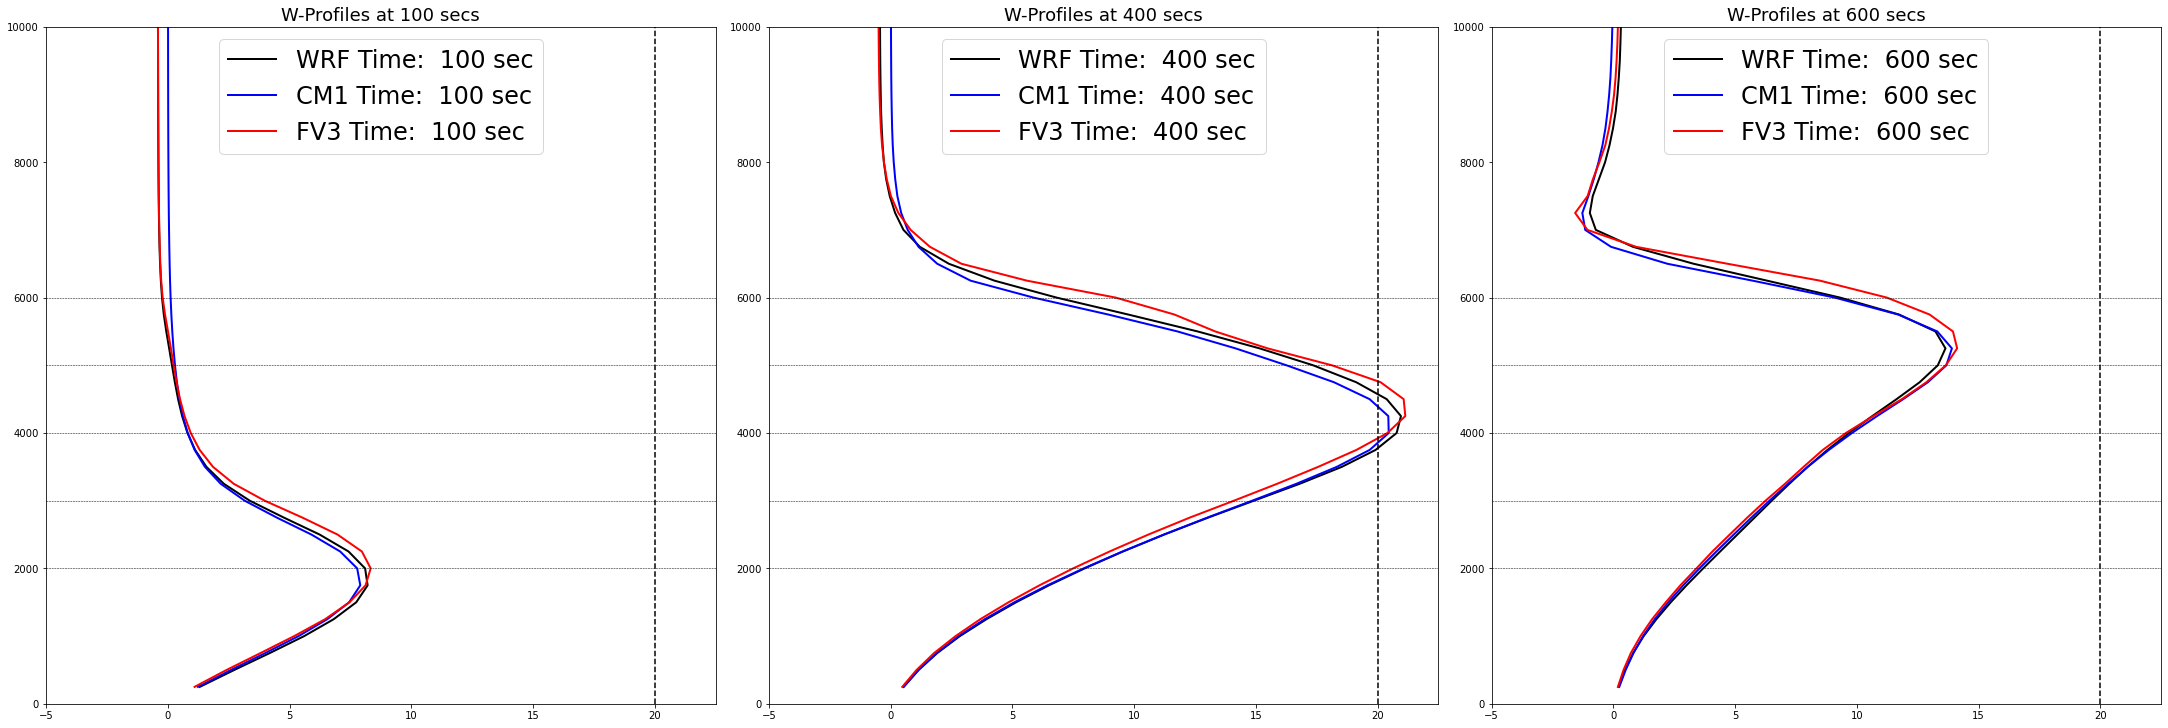

In [91]:
def plot_wprofile(profile, zhgts, time, thetime, ax, color, mlabel, linewidth=2.0):

    label = "%s Time:  %d sec" % (mlabel, thetime*10)
    
    ax.plot(profile[:,time], zhgts, color=color, linewidth=linewidth, label=label)
    
titles = "Updraft Profiles"

xvert  = 20.0
xlim   = 22.5

lcolors = ['k','b','r','g']

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(30,10))

for n, time in enumerate([10,40,60]):
    
    ax0 = ax[n]

    plot_wprofile(wrf_profiles['w'], zhgts, time, time, ax0, lcolors[0], 'WRF')
    plot_wprofile(cm1_profiles['w'], zhgts, time, time, ax0, lcolors[1], 'CM1')
    plot_wprofile(fv3_test_profiles['w'], zhgts, time-1, time, ax0, lcolors[2], 'FV3')
    ax0.set_title("W-Profiles at %d secs" % (time*10),  fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,10000.)
    ax0.set_xlim(-5.0,xlim)
    ax0.legend(fontsize=24)
    
plt.show()



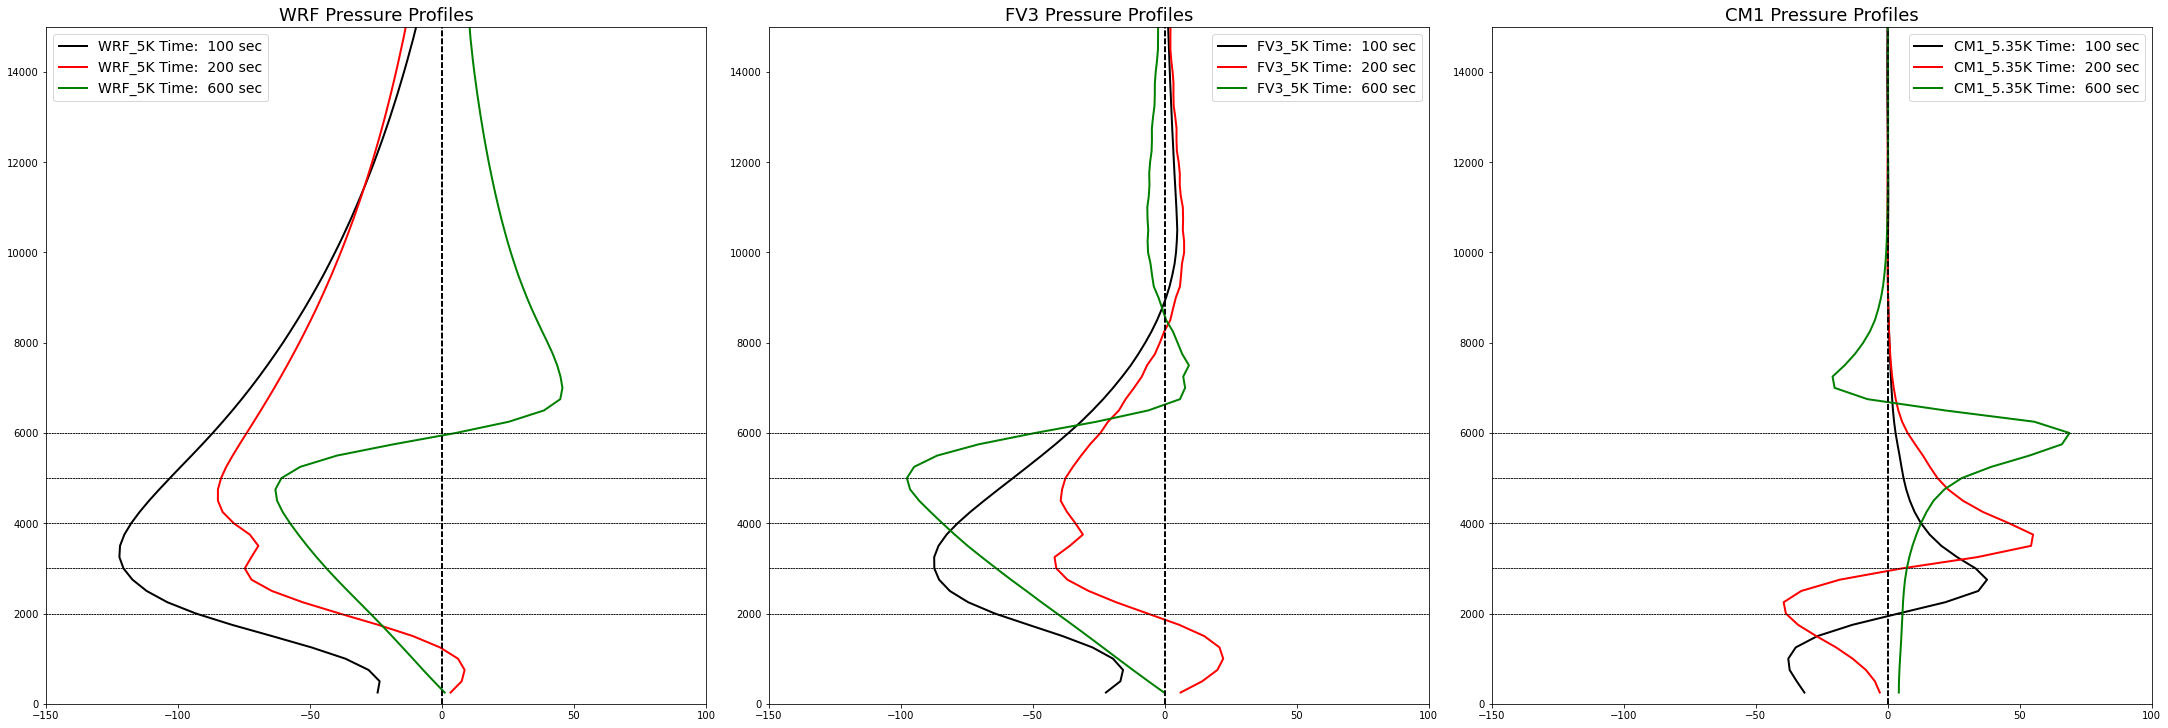

In [37]:
def plot_pprofile(profile, zhgts, time, thetime, ax, color, mlabel, linewidth=2.0):

    label = "%s Time:  %d sec" % (mlabel, thetime*10)
    
    ax.plot(profile[:,time], zhgts, color=color, linewidth=linewidth, label=label)
    
titles = "Pressure Profiles"

xvert  = 0
xlim   = [-150,100]

lcolors = ['k','r','g','b','r','m','k']

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(30,10))

for n, time in enumerate([10,20,60]):
    
    ax0 = ax[0]
    plot_pprofile(wrf_profiles['p'], zhgts, time, time, ax0, lcolors[n], 'WRF_5K')
    ax0.set_title("WRF %s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(loc=2,fontsize=14)
    
    ax0 = ax[1]
    plot_pprofile(fv3_profiles['p'], zhgts, time-1, time, ax0, lcolors[n], 'FV3_5K')
    ax0.set_title("FV3 %s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(fontsize=14)
    
    ax0 = ax[2]
    plot_pprofile(cm1_profiles['p'], zhgts, time, time, ax0, lcolors[n], 'CM1_5.35K')
    ax0.set_title("CM1 %s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(fontsize=14)

plt.show()

In [ ]:
def plot_wprofile(profile, zhgts, time, thetime, ax, color, mlabel, linewidth=2.0):

    label = "%s Time:  %d sec" % (mlabel, thetime*10)
    
    if len(time) != 0:
        
        ax.plot(profile[:,time[0]:time[1]].mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label)
        
    else:
        ax.plot(profile[:,time], zhgts, color=color, linewidth=linewidth, label=label)
    


lcolors = ['c','b','k']
llinewidth = [2.0, 2.0]

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(25,10))


wrf_vpgf   = -(wrf_profiles['p'][1:,:] - wrf_profiles['p'][:-1,:])/(0.5*(wrf_profiles['d'][1:,:] + wrf_profiles['d'][:-1,:]))
fv3_vpgf   = -(fv3_profiles['p'][1:,:] - fv3_profiles['p'][:-1,:])/(0.5*(fv3_profiles['d'][1:,:] + fv3_profiles['d'][:-1,:]))
cm1_vpgf   = -(cm1_profiles['p'][1:,:] - cm1_profiles['p'][:-1,:])/(0.5*(cm1_profiles['d'][1:,:] + cm1_profiles['d'][:-1,:]))
zhgts_vpgf = 0.5*(zhgts[1:] + zhgts[:-1])

for n, time in enumerate([1]):
    
    titles = "Updraft Profiles"
    
    xvert  = 20.0
    xlim   = 22.5
    
    delta = 3
    dtime = [time-delta, time+delta]
    dftime = [time-delta-1, time+delta-1]
    
    ax0 = ax[0]
    plot_wprofile(wrf_profiles['w'],       zhgts, dtime,  time, ax0, 'k', 'WRF', linewidth=llinewidth[n])
    plot_wprofile(fv3_profiles['w'],       zhgts, dftime, time, ax0, 'r', 'FV3', linewidth=llinewidth[n])
    plot_wprofile(cm1_profiles['w'],       zhgts, dtime,  time, ax0, 'b', 'CM1_5.35K', linewidth=llinewidth[n])
    ax0.set_title("%s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(-5.0,xlim)
    ax0.legend(fontsize=14)
    
    xvert  = 0
    xlim   = [-150,100]
    
    titles = "Pressure Profiles"
    ax0 = ax[1]
    plot_wprofile(wrf_profiles['p'], zhgts, dtime,   time, ax0, 'k', 'WRF', linewidth=llinewidth[n])
    plot_wprofile(fv3_profiles['p'], zhgts, dftime,  time, ax0, 'r', 'FV3', linewidth=llinewidth[n])
    plot_wprofile(cm1_profiles['p'], zhgts, dtime,   time, ax0, 'b', 'CM1_5.35K', linewidth=llinewidth[n])
    ax0.set_title("%s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(fontsize=14)

    xvert  = 0
    xlim   = [-50,50]
    
    titles = "Vertical Acceleration from V-PGF (hPa per 250 m)"
    ax0 = ax[2]
    
    plot_wprofile(wrf_vpgf, zhgts_vpgf, dtime,   time, ax0, 'k', 'WRF', linewidth=llinewidth[n])
    plot_wprofile(fv3_vpgf, zhgts_vpgf, dftime, time, ax0, 'r', 'FV3', linewidth=llinewidth[n])
    plot_wprofile(cm1_vpgf, zhgts_vpgf, dtime,   time, ax0, 'b', 'CM1_5.35K', linewidth=llinewidth[n])
    ax0.set_title("%s" % titles, fontsize=18)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(loc=1,fontsize=14)

plt.show()

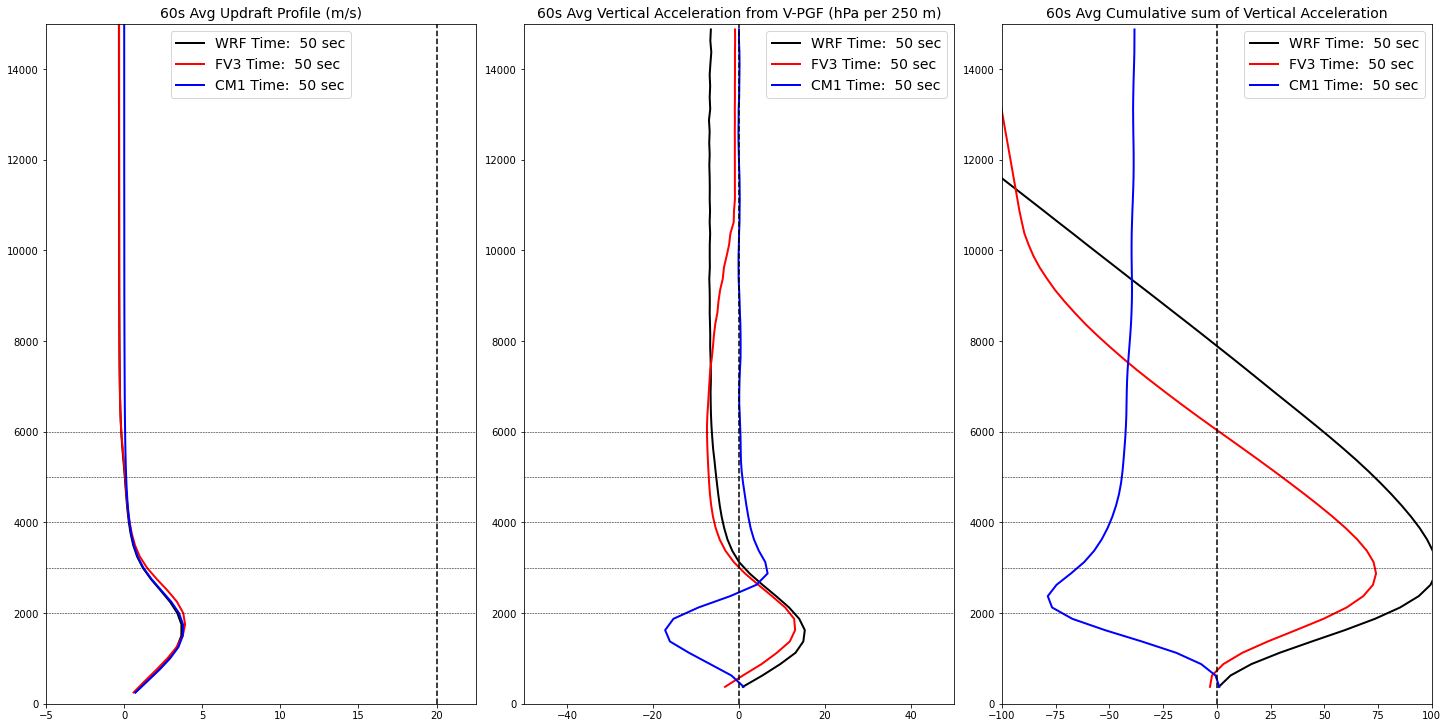

In [43]:
def plot_wprofile(profile, zhgts, time, thetime, ax, color, mlabel, linewidth=2.0):

    label = "%s Time:  %d sec" % (mlabel, thetime*10)
    
    if len(time) != 0:
        ax.plot(profile[:,time[0]:time[1]].mean(axis=1), zhgts, color=color, linewidth=linewidth, label=label)
        
    else:
        ax.plot(profile[:,time], zhgts, color=color, linewidth=linewidth, label=label)


lcolors = ['c','b','k']
llinewidth = [2.0, 2.0]

fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,10))


wrf_vpgf   = -(wrf_profiles['p'][1:,:] - wrf_profiles['p'][:-1,:])/(0.5*(wrf_profiles['d'][1:,:] + wrf_profiles['d'][:-1,:]))
fv3_vpgf   = -(fv3_profiles['p'][1:,:] - fv3_profiles['p'][:-1,:])/(0.5*(fv3_profiles['d'][1:,:] + fv3_profiles['d'][:-1,:]))
cm1_vpgf   = -(cm1_profiles['p'][1:,:] - cm1_profiles['p'][:-1,:])/(0.5*(cm1_profiles['d'][1:,:] + cm1_profiles['d'][:-1,:]))
zhgts_vpgf = 0.5*(zhgts[1:] + zhgts[:-1])

wrf_sum = np.cumsum(wrf_vpgf,axis=0)
fv3_sum = np.cumsum(fv3_vpgf,axis=0)
cm1_sum = np.cumsum(cm1_vpgf,axis=0)

for n, time in enumerate([5]):
    
    titles = "60s Avg Updraft Profile (m/s)"
    
    xvert  = 20.0
    xlim   = 22.5
    
    delta = 3
    dtime = [time-delta, time+delta]
    dftime = [time-delta-1, time+delta-1]

    ax0 = ax[0]
    plot_wprofile(wrf_profiles['w'], zhgts, dtime,  time, ax0, 'k', 'WRF', linewidth=llinewidth[n])
    plot_wprofile(fv3_profiles['w'], zhgts, dftime, time, ax0, 'r', 'FV3', linewidth=llinewidth[n])
    plot_wprofile(cm1_profiles['w'], zhgts, dtime,  time, ax0, 'b', 'CM1', linewidth=llinewidth[n])

    ax0.set_title("%s" % titles, fontsize=14)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(-5.0,xlim)
    ax0.legend(fontsize=14)
    
    xvert  = 0
    xlim   = [-50,50]

    titles = "60s Avg Vertical Acceleration from V-PGF (hPa per 250 m)"
    ax0 = ax[1]
    
    plot_wprofile(wrf_vpgf, zhgts_vpgf, dtime, time, ax0, 'k', 'WRF', linewidth=llinewidth[n])
    plot_wprofile(fv3_vpgf, zhgts_vpgf, dtime, time, ax0, 'r', 'FV3', linewidth=llinewidth[n])
    plot_wprofile(cm1_vpgf, zhgts_vpgf, dtime, time, ax0, 'b', 'CM1', linewidth=llinewidth[n])
    ax0.set_title("%s" % titles, fontsize=14)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(loc=1,fontsize=14)

    xvert  = 0
    xlim   = [-100,100]
    
    titles = "60s Avg Cumulative sum of Vertical Acceleration"
    ax0 = ax[2]
    plot_wprofile(wrf_sum, zhgts_vpgf, dtime, time, ax0, 'k', 'WRF', linewidth=llinewidth[n])
    plot_wprofile(fv3_sum, zhgts_vpgf, dtime, time, ax0, 'r', 'FV3', linewidth=llinewidth[n])

    plot_wprofile(cm1_sum, zhgts_vpgf, dtime, time, ax0, 'b', 'CM1', linewidth=llinewidth[n])
    ax0.set_title("%s" % titles, fontsize=14)
    ax0.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax0.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    ax0.axvline(x=xvert, color='k', linestyle='--')
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(fontsize=14)


plt.show()

<ipython-input-86-65eca04d9fe0>:55: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contourf(xgrid2D, zfld, tfld, vmax=6.0, vmin=-6.0, label=label, cmap='viridis')
<ipython-input-86-65eca04d9fe0>:56: UserWarning: The following kwargs were not used by contour: 'label', 'linewidth'
  ax.contour(xgrid2D, zfld, wfld, levels=clevels, colors='k', label=label, linewidth=0.5)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


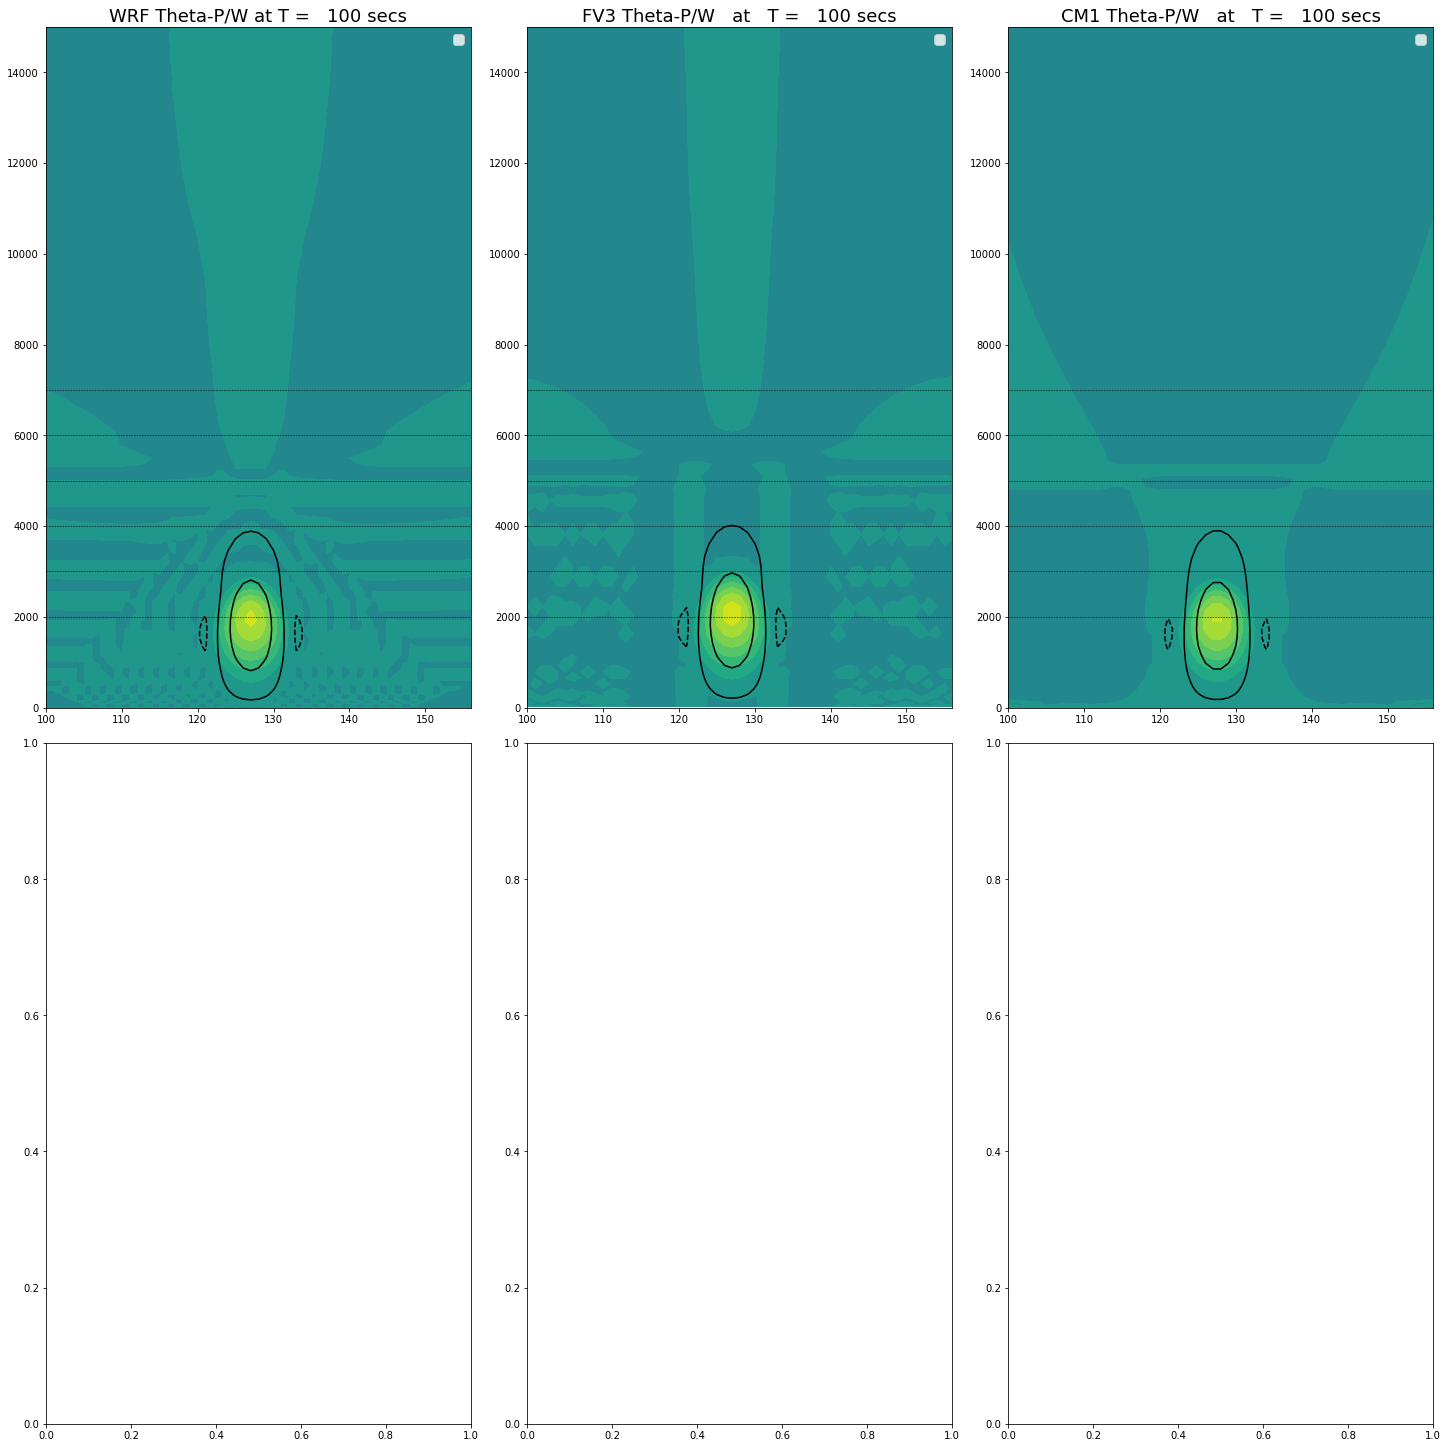

In [86]:
def plot_xz(xgrid, zhgts, field, z3d, time, thetime, ax, color, mlabel, linewidth=2.0, base_state=None):

    label = "%s Time:  %d sec" % (mlabel, thetime*10)
    
    
    if base_state == None:
        
        fld   = field[time,0:59,:,127]
        zfld  = z3d[time,0:59,:,127]
        
    else:
        
        rfld  = field[time,0:59,:,127]
        zfld  = z3d[time,0:59,:,127]
        rbase = base[time,0:59,:,127]

        fld = interp3dz_np(rfld, zfld, zhgts, nthreads = _nthreads) - interp3dz_np(rbase, zfld, zhgts, nthreads = _nthreads)
    
    xgrid2D = np.broadcast_to(xgrid[np.newaxis,:], zfld.shape)
    
    print(mlabel)
    
    ax.contourf(xgrid2D, zfld, fld, cint=0.5, label=label)

    ax.axhline(y=7000., color='k', linestyle='--',linewidth=0.5)
    ax.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)

def plot_xzWT(xgrid, zhgts, thetap, w, z3d, time, thetime, ax, color, mlabel, linewidth=2.0, base_state=None):

    label = "%s Time:  %d sec" % (mlabel, thetime*10)
    
    if base_state == None:
        
        wfld = w[time,0:59,:,127]
        tfld = thetap[time,0:59,:,127]
        zfld = z3d[time,0:59,:,127]
        
    else:
        
        rfld  = field[time,0:59,:,127]
        zfld  = z3d[time,0:59,:,127]
        rbase = base[time,0:59,:,127]

        fld = interp3dz_np(rfld, zfld, zhgts, nthreads = _nthreads) - interp3dz_np(rbase, zfld, zhgts, nthreads = _nthreads)
    
    xgrid2D = np.broadcast_to(xgrid[np.newaxis,:], zfld.shape)
    
    clevels = [-5., -1.0, 1, 5, 10, 15, 20]
    
    #ax.pcolormesh(xgrid2D, zfld, tfld, shading='auto', vmax=1.0, vmin=-5.0, cmap='viridis')
    ax.contourf(xgrid2D, zfld, tfld, vmax=6.0, vmin=-6.0, label=label, cmap='viridis')
    ax.contour(xgrid2D, zfld, wfld, levels=clevels, colors='k', label=label, linewidth=0.5)

    ax.axhline(y=7000., color='k', linestyle='--',linewidth=0.5)
    ax.axhline(y=6000., color='k', linestyle='--',linewidth=0.5)
    ax.axhline(y=5000., color='k', linestyle='--',linewidth=0.5)
    ax.axhline(y=4000., color='k', linestyle='--',linewidth=0.5)
    ax.axhline(y=3000., color='k', linestyle='--',linewidth=0.5)
    ax.axhline(y=2000., color='k', linestyle='--',linewidth=0.5)
    
titles = "Updraft Profiles"

xvert  = 20.0
xlim   = [100,156]

lcolors = ['y','c','g','b','r','m','k']

fig, ax = plt.subplots(2,3, constrained_layout=True,figsize=(20,20))

xgrid = np.arange(256)

for n, time in enumerate([10]):
    
    ax0 = ax[0,0]
    #plot_xz(xgrid, zhgts, wrf_fields['thetap'], wrf_fields['z3d'], time, time, ax0, lcolors[n], 'WRF')
    plot_xzWT(xgrid, zhgts, wrf_fields['thetap'], wrf_fields['w'], wrf_fields['z3d'], time, time, ax0, lcolors[n], 'WRF')
    ax0.set_title("WRF %s  %d secs" % ("Theta-P/W at T = ", time*10), fontsize=18)
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(fontsize=14)
    
    # ax0 = ax[1,0]
    # #plot_xz(xgrid, zhgts, wrf_fields['ppres'], wrf_fields['z3d'], time, time, ax0, lcolors[n], 'WRF')
    # ax0.set_title("WRF %s  %d secs" % ("nh-P'   at   T = ", time*10), fontsize=18)
    # ax0.set_ylim(0.0,15000.)
    # ax0.set_xlim(xlim)
    # ax0.legend(fontsize=14)

    ax0 = ax[0,1]
    #plot_xz(xgrid, zhgts, fv3_test['thetap'], fv3_test['z3d'], time-1, time, ax0, lcolors[n], 'FV3')
    plot_xzWT(xgrid, zhgts, fv3_fields['thetap'], fv3_fields['w'], fv3_fields['z3d'], time-1, time, ax0, lcolors[n], 'FV3')
    ax0.set_title("FV3 %s  %d secs" % ("Theta-P/W   at   T = ", time*10), fontsize=18)
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(fontsize=14)

#     ax0 = ax[1,1]
#     plot_xz(xgrid, zhgts, fv3_test['ppres'], fv3_test['z3d'], time-1, time, ax0, lcolors[n], 'FV3')
#     ax0.set_title("FV3 %s  %d secs" % ("nh-P'   at   T = ", time*10), fontsize=18)
#     ax0.set_ylim(0.0,15000.)
#     ax0.set_xlim(xlim)
#     ax0.legend(fontsize=14)

    ax0 = ax[0,2]
    #plot_xz(xgrid, zhgts, cm1_fields['thetap'], cm1_fields['z3d'], time, time, ax0, lcolors[n], 'CM1')
    plot_xzWT(xgrid, zhgts, cm1_fields['thetap'], cm1_fields['w'], cm1_fields['z3d'], time, time, ax0, lcolors[n], 'CM1')
    ax0.set_title("CM1 %s  %d secs" % ("Theta-P/W   at   T = ", time*10), fontsize=18)
    ax0.set_ylim(0.0,15000.)
    ax0.set_xlim(xlim)
    ax0.legend(fontsize=14)
    
#     ax0 = ax[1,2]
#     plot_xz(xgrid, zhgts, cm1_fields['ppres'], cm1_fields['z3d'], time, time, ax0, lcolors[n], 'CM1')
#     ax0.set_title("CM1 %s  %d secs" % ("nh-P'   at   T = ", time*10), fontsize=18)
#     ax0.set_ylim(0.0,15000.)
#     ax0.set_xlim(xlim)
#     ax0.legend(fontsize=14)

plt.show()


